# Detección Sonora de Ballenas Francas

> Juan Pablo Yamamoto Zazueta  
> [jpyamamoto@ciencias.unam.mx](mailto:jpyamamoto.ciencias.unam.mx)

## Instalación e inicialización de entorno

### Instalación de Dependencias

In [1]:
!pip install opendatasets

In [2]:
!pip install librosa

In [3]:
!pip install scipy

In [4]:
!pip install torch torchvision

### Importar Dependencias

In [5]:
# Visualización

from IPython.display import Audio, display, HTML, IFrame, clear_output
from ipywidgets import interact, widgets
from matplotlib import pyplot as plt

In [6]:
# Utilidades

import glob
import numpy as np
import os
import csv
import time

In [7]:
# Herramientas

import opendatasets as od
import librosa
from scipy.fft import fft
from PIL import Image

In [8]:
# Red Neuronal

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.ops.focal_loss import sigmoid_focal_loss

## Preparación de los datos

El conjunto de datos fue desarrollado por André Karpištšenko, Eric Spaulding y Will Cukierski, a través de Kaggle en la competencia ["The Marinexplore and Cornell University Whale Detection Challenge"](https://kaggle.com/competitions/whale-detection-challenge).

Podemos descargarlo desde Kaggle utilizando la biblioteca `opendatasets`.

**Nota:** Primero dirígete al sitio web de la competencia ([https://www.kaggle.com/competitions/whale-detection-challenge/data](https://www.kaggle.com/competitions/whale-detection-challenge/data)) y acepta el aviso de Copyright para poder descargar el conjunto de datos.

Posteriormente, descarga tus credenciales para usar la API de Kaggle en la configuración de tu perfil, y coloca el archivo `kaggle.json` en el mismo directorio de este archivo (para ser detectado automáticamente) o copia y pega el contenido del archivo en la entrada que se desplegará al ejecutar la siguiente celda.

In [ ]:
od.download("https://www.kaggle.com/competitions/whale-detection-challenge/data")

Procedemos a organizar los archivos en que recibimos los datos, de manera que sean fácil de explorar.

La primera celda mueve los datos de ejemplo a la carpeta `sample`, y la segunda celda pone los archivos para entrenamiento y pruebas en la carpeta `data`.

In [ ]:
%%capture
# Capturamos la salida porque son demasiados archivos y ocupan mucho espacio en el notebook

!unzip whale-detection-challenge/small_data_sample_revised.zip -d sample/
!cp whale-detection-challenge/sample_submission.csv sample/
!rm -r sample/__MACOSX
!mv sample/small_data_sample/* sample/
!rm -r sample/small_data_sample/

In [ ]:
%%capture
# Capturamos la salida porque son demasiados archivos y ocupan mucho espacio en el notebook

!unzip whale-detection-challenge/whale_data.zip -d .

In [ ]:
archivos_entrenamiento = glob.glob('./data/train/*.aiff')
archivos_prueba = glob.glob('./data/test/*.aiff')

print("Archivos de entrenamiento: {}".format(len(archivos_entrenamiento)))
print("Archivos de test: {}".format(len(archivos_prueba)))

Para manipular los archivos de audio que se encuentran en formato `.aiff`, vamos a utilizar la biblioteca [librosa](https://librosa.org/) que incluye varias herramientas relacionadas al procesamiento de audio.

Podemos explorar algunos ejemplos de las grabaciones que tiene el conjunto con los archivos contenidos en el directorio `sample`:

In [ ]:
archivos_no_whale = glob.glob('./sample/no_right_whale/*.aiff')
samples_no_whale = [librosa.load(file, sr=None) for file in archivos_no_whale]

archivos_whale = glob.glob('./sample/right_whale/*.aiff')
samples_whale = [librosa.load(file, sr=None) for file in archivos_whale]

In [ ]:
no_whale, samplerate_nw = librosa.load('./sample/no_right_whale/train1.aiff')
whale, samplerate_w = librosa.load('./sample/right_whale/train9.aiff')

print("No whale:")
display(Audio(no_whale, rate=samplerate_nw))
print("Whale:")
display(Audio(whale, rate=samplerate_w))

Todos los audios cumplen con las siguientes especificaciones:

- Duración: 2 segundos
- Frecuencia de muestreo: 2 kHz

Debemos tener cuidado al utilizar la biblioteca `librosa`, pues por defecto va a hacer un resampling.

In [ ]:
_, samplerate_original = samples_no_whale[0]
_, samplerate_default = librosa.load('./sample/no_right_whale/train1.aiff')

print("Frecuencia de muestreo original: {} Hz".format(samplerate_original))
print("Frecuencia de muestreo por defecto: {} Hz".format(samplerate_default))

## Análisis de los datos

Primero que nada, para poder procesar datos de audio tenemos que entender la forma en que se representa el audio digitalmente.

Lo que un micrófono haría es medir la presión relativa que ejerce el medio (normalmente aire, pero en nuestro caso el medio sería agua) sobre el dispositivo de captura. De manera tal que una mayor presión representa una onda enviada a través del medio con mayor fuerza.

Por otro lado, esta presión al ser en realidad la medición de ondas, tiene otra propiedad: la frecuencia. Cuando vemos la representación de una onda, según la cercanía de dos crestas de la onda es la frecuencia del sonido que escuchamos.

Si bien esta presión en el mundo real se considera una función continua, para trabajar con ella digitalmente, tenemos que discretizarla. Para esto se toman muestras en intervalos de tiempo bien definidos, y se redondean a un valor representable según la precisión con que cuenta la computadora.

Esta es, a grandes rasgos, la manera en que se almacena audio de forma digital. Esto nos lleva a la primera visualización que podemos hacer de los datos que tenemos, y es la visualización por amplitud de onda:

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 9))
plots = [ax1, ax2, ax3, ax4, ax5]

fig.suptitle('Amplitud de Onda: Sin Ballenas')

for ax, sample in zip(plots, samples_no_whale):
    audio = sample[0]
    ax.plot(audio)
    ax.set_xlim([0, audio.shape[0]])
    ax.set_ylim([-0.1, 0.1])
    ax.set_xlabel('Muestra')
    ax.set_ylabel('Amplitud')
    
ax6.axis('off');

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 9))
plots = [ax1, ax2, ax3, ax4, ax5]

fig.suptitle('Amplitud de Onda: Con Ballenas')

for ax, sample in zip(plots, samples_whale):
    audio = sample[0]
    ax.plot(audio)
    ax.set_xlim([0, audio.shape[0]])
    ax.set_ylim([-0.1, 0.1])
    ax.set_xlabel('Muestra')
    ax.set_ylabel('Amplitud')
    
ax6.axis('off');

Como mencionamos anteriormente, la frecuencia de un sonido depende de la cercanía entre dos crestas de la onda medida. Por otro lado, al discretizar la onda, únicamente podemos tomar medidas cada cierto intervalo de tiempo. Esto quiere decir que ciertas frecuencias requieren mayor cantidad de mediciones para ser capturadas apropiadamente, y otras requieren menos.

La medida de cuántas muestras debemos tomar para poder recuperar de manera apropiada la frecuencia grabada en un audio, es la [frecuencia Nyquist](https://mathworld.wolfram.com/NyquistFrequency.html), la cuál indica lo siguiente:

La mayor frecuencia $f_{\text{Nyquist}}$ que puede ser capturada con una tasa de muestreo $v$, es $f(v)=\dfrac{1}{2}v$.

Eso nos da una primera pista sobre nuestros datos: si la frecuencia de muestreo es de 2 kHz, eso quiere decir que la máxima frecuencia registrada en el sonido puede ser de 1 kHz.

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 9))
plots = [ax1, ax2, ax3, ax4, ax5]

fig.suptitle('Densidad Espectral: Sin Ballenas')

for ax, sample in zip(plots, samples_no_whale):
    audio, sr = sample
    X = fft(audio)
    f = np.linspace(0, sr, len(X))
    ax.plot(f, X)
    ax.set_xlim([0, f.shape[0]/2])
    ax.set_xlabel('Frecuencia (Hz)')
    ax.set_ylabel('Magnitud')
    
ax6.axis('off');

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 9))
plots = [ax1, ax2, ax3, ax4, ax5]

fig.suptitle('Densidad Espectral: Con Ballenas')

for ax, sample in zip(plots, samples_whale):
    audio, sr = sample
    X = fft(audio)
    f = np.linspace(0, sr, len(X))
    ax.plot(f, X)
    ax.set_xlim([0, f.shape[0]/2])
    ax.set_xlabel('Frecuencia (Hz)')
    ax.set_ylabel('Magnitud')
    
ax6.axis('off');

Podemos ver en los ejemplos que efectivamente, las frecuencias capturadas se encuentran entre 0 y 1000 Hz. Tenemos valores hasta 2 kHz por la forma en que funciona la transformada de Fourier, que refleja los resultados sobre la frecuencia de Nyquist (en nuestro caso, recordemos que era 1000).

Sin embargo, esto sigue sin darnos suficiente información para detectar el sonido de las ballenas. Notemos que las gráficas son bastante parecidas en ambas categorías, a excepción de algunos casos donde las grabaciones con ballenas parecen tener magnitudes más grandes.

Sin embargo, no podemos confiar en esto, pues no sabemos si esas frecuencias son causadas por las ballenas o por cualquier otro factor en la grabación.

## Conociendo a las Ballenas

Investigando más sobre las ballenas francas y los sonidos que hacen, encontramos los siguientes datos relevantes:

- Producen 3 tipos de sonidos: gemidos, quejidos y eruptos.
- La mayoría de los sonidos que producen se mantienen por debajo de los 500 Hz.
- Pocas veces emiten sonidos que alcanzan hasta los 4 kHz.
- El sonido distintivo de las ballenas francas es el "whoop" o "up call":
    - Sube de los 50 Hz a los 440 Hz.
    - Dura alrededor de 2 segundos.
    - Se utiliza para llamar a otras ballenas francas y generalmente las atrae a reunirse.
    - Es un sonido que emiten de manera constante y común.
    - Es el sonido más comúnmente utilizado por los expertos para identificar ballenas francas.
    
De los datos anteriores, considero que la mejor vía para detectar a las ballenas es usando el sonido "whoop", confiando en lo que hacen los expertos. Esto nos ayuda a identificar qué tipo de patrones buscar:
- Incremento en la frecuencia.
- Comienza cerca de 50 Hz y sube cerca de 440 Hz.
- Presente en la duración de la grabación.

A continuación podemos ver una grabación donde se escucha el sonido "whoop". Una grabación más clara de este sonido se escucha en el siguiente video que no podemos incrustar en el notebook por restricciones impuestas por la plataforma donde se publicó: [North Atlantic Right Whale "up call"](https://vimeo.com/227009627).

In [ ]:
IFrame(src="https://www.youtube.com/embed/1WFnX4zO9GU", height=315, width=560)

Podemos ver en los videos que se están usando espectrogramas para visualizar las frecuencias del sonido, y en ambos vemos unas curvas convexas.

Esto concuerda con la imagen provista en la página del concurso, distinguiendo el sonido de la ballena franca:

![Imagen Espectrograma](https://storage.googleapis.com/kaggle-competitions/kaggle/3353/media/whale_detection_challenge-cwc-es.png)

Si bien la visualización de amplitud de onda nos puede dar una idea de qué frecuencias colaboran a la onda durante los 2 segundos de grabación, no es suficiente conocer que hay sonidos en las frecuencias 50 - 440 kHz. También necesitamos saber que siguen el patrón ascendente. De otra manera podría ser que hay otros factores generando sonidos en esas frecuencias, sin estar relacionados.

Por lo tanto, tenemos que visualizar las frecuencias no sólo por su contribución a la onda total, sino considerando también su magnitud en el tiempo. Para ello vamos a utilizar los **espectrogramas**.

## Espectrogramas

Para visualizar las frecuencias que componen una onda a través del dominio del tiempo, podemos usar espectrogramas. Estos van a descomponer la onda en sus frecuencias, en una cierta ventana de tiempo. Luego, va a utilizar códigos de color para mostrar la intensidad en decibelios de una cierta frecuencia en cada intervalo.

Podemos visualizarlo de la siguiente manera:

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 15))
plots = [ax1, ax2, ax3, ax4, ax5]

fig.suptitle('Espectrograma de Frecuencias: Sin Ballenas')
img = None

for ax, sample in zip(plots, samples_no_whale):
    audio, sr = sample
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax)
    ax.set_xlabel('Tiempo (segundos)')
    ax.set_ylabel('Frecuencia')
    
ax6.axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])
fig.colorbar(img, cax=cbar_ax, format="%+2.f dB");

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 15))
plots = [ax1, ax2, ax3, ax4, ax5]

fig.suptitle('Espectrograma de Frecuencias: Con Ballenas')
img = None

for ax, sample in zip(plots, samples_whale):
    audio, sr = sample
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax)
    ax.set_xlabel('Tiempo (segundos)')
    ax.set_ylabel('Frecuencia')
    
ax6.axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])
fig.colorbar(img, cax=cbar_ax, format="%+2.f dB");

Como podemos ver, los espectrogramas contienen demasiada información en un comienzo, y no son precisamente informativos. Vamos a intentar limpiar un poco más los datos para ser capaces de extraer la información relevante a nuestro problema.

Una primera mejora que podemos intentar aplicar es únicamente considerar las frecuencias en el rango 0 Hz - 500 Hz. Esto es porque, como vimos antes, es el rango de frecuencias que emiten las ballenas.

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
plots = [ax1, ax2, ax3, ax4, ax5]

fig.suptitle('Espectrograma de Frecuencias: Sin Ballenas')
img = None

for ax, sample in zip(plots, samples_no_whale):
    audio, sr = sample
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax)
    ax.set_ylim([0, 500])
    ax.set_xlabel('Tiempo (segundos)')
    ax.set_ylabel('Frecuencia')
    
ax6.axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])
fig.colorbar(img, cax=cbar_ax, format="%+2.f dB");

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
plots = [ax1, ax2, ax3, ax4, ax5]

fig.suptitle('Espectrograma de Frecuencias: Con Ballenas')
img = None

for ax, sample in zip(plots, samples_whale):
    audio, sr = sample
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax)
    ax.set_ylim([0, 500])
    ax.set_xlabel('Tiempo (segundos)')
    ax.set_ylabel('Frecuencia')
    
ax6.axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])
fig.colorbar(img, cax=cbar_ax, format="%+2.f dB");

Ahora estamos limitando los espectrogramas a frecuencias hasta los 500 Hz. Igualmente notemos que los intervalos de tiempo son demasiado amplios. Si contamos las divisiones verticales, encontramos que solo hay 8 ventanas de tiempo en las que estamos midiendo las frecuencias.

El algoritmo que utilizamos (Short Time Fourier Transform) requiere que indiquemos los siguientes parámetros:
- Tamaño del intervalo: La cantidad de muestras que se van a considerar en la ventana a la que se aplica la transformada de Fourier.
- Tamaño del salto: La cantidad de muestras a desplazarnos entre una ventana de tiempo y la siguiente.

En realidad no hay una medida concreta sobre qué valores deben tomar esas variables. Mediante prueba y error (podemos hacer la prueba en la siguiente celda) encontramos valores que nos convencieron pues parecen entregar imágenes descriptivas, sin ser de un tamaño no manejable.


In [ ]:
@interact(
    frame_size = widgets.IntSlider(min=10, max=500, step=1, value=256),
)
def visualize_stft(frame_size):
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))
    
    hop_length = frame_size // 4

    fig.suptitle('Espectrograma (Intervalo: {}, Salto: {})'.format(frame_size, hop_length))

    audio_nw, sr_nw = samples_no_whale[4]
    audio_w, sr_w = samples_whale[4]
    
    D_nw = librosa.amplitude_to_db(np.abs(librosa.stft(audio_nw, hop_length=hop_length, n_fft=frame_size)), ref=np.max)
    img = librosa.display.specshow(D_nw, y_axis='linear', x_axis='time', hop_length=hop_length, n_fft=frame_size, sr=sr_nw, ax=ax1)
    
    D_w = librosa.amplitude_to_db(np.abs(librosa.stft(audio_w, hop_length=hop_length, n_fft=frame_size)), ref=np.max)
    img = librosa.display.specshow(D_w, y_axis='linear', x_axis='time', hop_length=hop_length, n_fft=frame_size, sr=sr_w, ax=ax2)
    
    ax1.set_ylim([0, 500])
    ax1.set_xlabel('Tiempo (segundos)')
    ax1.set_ylabel('Frecuencia')
    ax1.set_title('Sin Ballena')
    
    ax2.set_ylim([0, 500])
    ax2.set_xlabel('Tiempo (segundos)')
    ax2.set_ylabel('Frecuencia')
    ax2.set_title('Con Ballena')
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])
    fig.colorbar(img, cax=cbar_ax, format="%+2.f dB");

Algunos consejos para seleccionar esos valores, que encontramos son los siguientes:
- Que el tamaño del intervalo sea una potencia de 2.
- Que el tamaño del salto sea una cuarta parte del tamaño del intervalo.

Por ello, habiendo encontrado valores que nos convencieron en la celda anterior, redondeamos el tamaño del intervalo a la potencia de 2 más cercana y dimos el tamaño del salto una cuarta parte de este.

Esto nos dio los siguientes valores:

In [ ]:
frame_size = 256
hop_length = frame_size // 4

print("Tamaño del intervalo: {}".format(frame_size))
print("Tamaño del salto: {}".format(hop_length))

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
plots = [ax1, ax2, ax3, ax4, ax5]

fig.suptitle('Espectrograma de Frecuencias: Sin Ballenas')
img = None

for ax, sample in zip(plots, samples_no_whale):
    audio, sr = sample
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio, hop_length=hop_length, n_fft=frame_size)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time', hop_length=hop_length, n_fft=frame_size, sr=sr, ax=ax)
    ax.set_ylim([0, 500])
    ax.set_xlabel('Tiempo (segundos)')
    ax.set_ylabel('Frecuencia')
    
ax6.axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])
fig.colorbar(img, cax=cbar_ax, format="%+2.f dB");

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
plots = [ax1, ax2, ax3, ax4, ax5]

fig.suptitle('Espectrograma de Frecuencias: Con Ballenas')
img = None

for ax, sample in zip(plots, samples_whale):
    audio, sr = sample
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio, hop_length=hop_length, n_fft=frame_size)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time', hop_length=hop_length, n_fft=frame_size, sr=sr, ax=ax)
    ax.set_ylim([0, 500])
    ax.set_xlabel('Tiempo (segundos)')
    ax.set_ylabel('Frecuencia')
    
ax6.axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])
fig.colorbar(img, cax=cbar_ax, format="%+2.f dB");

### Espectrogramas de Mel

Hay un último hecho que queremos tomar en cuenta al momento de generar los espectrogramas. Esto es que los humanos (y en general los animales) no percibimos el sonido de forma lineal. Es decir, al reproducir dos frecuencias a un intervalo dado y luego reproducir dos notas al mismo intervalo en una frecuencia distinta (y asumamos que lejana), percibiremos claramente que un par suena más parecido que el otro.

Esto se debe a que el sonido se percibe de forma logarítmica. Mientras mayor es la frecuencia, más lejanas deben estar dos frecuencias para que el intervalo entre ellas se **perciba** como constante.

Puesto que esto es algo generalizado en los animales, podemos asumir que las ballenas también perciben de esta manera el sonido. Y por lo mismo parece apropiado asumir que la forma de analizar el sonido emitido por ellas debe ajustarse a esta métrica.

Para ello vamos a utilizar los espectrogramas de Mel.

En la imagen siguiente podemos visualizar cómo funciona el filtro que será aplicado a la imagen. Podemos ver que según la frecuencia del sonido, será la intensidad del filtro que se aplique.

La tasa de muestreo al ser baja (recordemos que era de 200), no permite visualizar tan claramente la forma logarítmica que tiene este filtro, debido a que son pocas las frecuencias alcanzables. Pero podemos hacer el experimento de incrementar la variable `sr` a un valor como `22050` (la tasa de muestreo estándar para archivos de música) y va a ser clara la diferencia.

In [ ]:
@interact(
    mel_bands = widgets.IntSlider(min=5, max=50, step=1, value=10),
)
def visualize_stft(mel_bands):
    fig, ax = plt.subplots()
    sr = 200
    filter_banks = librosa.filters.mel(n_fft=frame_size, sr=sr, n_mels=mel_bands)
    librosa.display.specshow(filter_banks, sr=sr, x_axis='linear')
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Espectrograma de los filtros de Mel')

Vamos a buscar el número apropiado de bandas de Mel para nuestro caso de uso. No encontré alguna fórmula o heurística para determinar este valor, sino que más bien la elección debe ir guiada por la resolución que da (y lo que esperamos ver en la imagen).

En la siguiente celda podemos experimentar con el valor que consideramos da un buen resultado.

In [ ]:
@interact(
    mel_bands = widgets.IntSlider(min=10, max=200, step=1, value=128),
)
def visualize_stft(mel_bands):
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))
    
    fig.suptitle('Espectrograma (Bandas de Mel: {})'.format(mel_bands))

    audio_nw, sr_nw = samples_no_whale[4]
    audio_w, sr_w = samples_whale[4]
    
    mel_spec_nw = librosa.feature.melspectrogram(y=audio_nw, sr=sr_nw, n_fft=frame_size, hop_length=hop_length, n_mels=mel_bands)
    mel_spec_w = librosa.feature.melspectrogram(y=audio_w, sr=sr_w, n_fft=frame_size, hop_length=hop_length, n_mels=mel_bands)
    
    D_nw = librosa.power_to_db(mel_spec_nw, ref=np.max)
    img = librosa.display.specshow(D_nw, y_axis='mel', x_axis='time', hop_length=hop_length, n_fft=frame_size, sr=sr_nw, ax=ax1)
    
    D_w = librosa.power_to_db(mel_spec_w, ref=np.max)
    img = librosa.display.specshow(D_w, y_axis='mel', x_axis='time', hop_length=hop_length, n_fft=frame_size, sr=sr_w, ax=ax2)
    
    ax1.set_ylim([0, 500])
    ax1.set_xlabel('Tiempo (segundos)')
    ax1.set_ylabel('Frecuencia')
    ax1.set_title('Sin Ballena')
    
    ax2.set_ylim([0, 500])
    ax2.set_xlabel('Tiempo (segundos)')
    ax2.set_ylabel('Frecuencia')
    ax2.set_title('Con Ballena')
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])
    fig.colorbar(img, cax=cbar_ax, format="%+2.f dB");

El valor que nos convenció fue el de la siguiente celda.

- Con valores más grandes, parece haber mucho ruido en la imagen.
- Con valores más pequeños se desvanecen algunos colores y perdemos información.

In [ ]:
mel_bands = 128

print("Bandas de Mel: {}".format(mel_bands))

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
plots = [ax1, ax2, ax3, ax4, ax5]

fig.suptitle('Espectrograma de Mel: Sin Ballenas')
img = None

for ax, sample in zip(plots, samples_no_whale):
    audio, sr = sample
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=frame_size, hop_length=hop_length, n_mels=mel_bands)
    D = librosa.power_to_db(mel_spec, ref=np.max)
    img = librosa.display.specshow(D, y_axis='mel', x_axis='time', hop_length=hop_length, n_fft=frame_size, sr=sr, ax=ax)
    ax.set_ylim([0, 500])
    ax.set_xlabel('Tiempo (segundos)')
    ax.set_ylabel('Frecuencia')
    
ax6.axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])
fig.colorbar(img, cax=cbar_ax, format="%+2.f dB");

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
plots = [ax1, ax2, ax3, ax4, ax5]

fig.suptitle('Espectrograma de Mel: Con Ballenas')
img = None

for ax, sample in zip(plots, samples_whale):
    audio, sr = sample
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=frame_size, hop_length=hop_length, n_mels=mel_bands)
    D = librosa.power_to_db(mel_spec, ref=np.max)
    img = librosa.display.specshow(D, y_axis='mel', x_axis='time', hop_length=hop_length, n_fft=frame_size, sr=sr, ax=ax)
    ax.set_ylim([0, 500])
    ax.set_xlabel('Tiempo (segundos)')
    ax.set_ylabel('Frecuencia')
    
ax6.axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])
fig.colorbar(img, cax=cbar_ax, format="%+2.f dB");

Finalmente, notemos que la forma en que utilizamos la escala de colores es lineal. Si bien para un humano es más fácil visualizar la intensidad por colores, la computadora lo va a leer como números de mayor o menor tamaño.

Por lo tanto, podemos convertir la imagen a escala de grises para facilitar su procesamiento por la red neuronal.

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
plots = [ax1, ax2, ax3, ax4, ax5]

fig.suptitle('Espectrograma de Mel: Sin Ballenas')
img = None

for ax, sample in zip(plots, samples_no_whale):
    audio, sr = sample
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=frame_size, hop_length=hop_length, n_mels=mel_bands)
    D = librosa.power_to_db(mel_spec, ref=np.max)
    img = librosa.display.specshow(D, cmap='gray', y_axis='mel', x_axis='time', hop_length=hop_length, n_fft=frame_size, sr=sr, ax=ax)
    ax.set_ylim([0, 500])
    ax.set_xlabel('Tiempo (segundos)')
    ax.set_ylabel('Frecuencia')
    
ax6.axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])
fig.colorbar(img, cax=cbar_ax, format="%+2.f dB");

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
plots = [ax1, ax2, ax3, ax4, ax5]

fig.suptitle('Espectrograma de Mel: Con Ballenas')
img = None

for ax, sample in zip(plots, samples_whale):
    audio, sr = sample
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=frame_size, hop_length=hop_length, n_mels=mel_bands)
    D = librosa.power_to_db(mel_spec, ref=np.max)
    img = librosa.display.specshow(D, cmap='gray', y_axis='mel', x_axis='time', hop_length=hop_length, n_fft=frame_size, sr=sr, ax=ax)
    ax.set_ylim([0, 500])
    ax.set_xlabel('Tiempo (segundos)')
    ax.set_ylabel('Frecuencia')
    
ax6.axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])
fig.colorbar(img, cax=cbar_ax, format="%+2.f dB");

## Procesamiento de las imágenes

Tras haber determinado la forma en que convertiremos los archivos de audio a imágenes, y encontrando la configuración adecuada, vamos a procesar los archivos para poder utilizarlos con la red neuronal.

In [ ]:
def audio_to_img(audio, sr):
    img = librosa.feature.melspectrogram(y=audio,
                                         sr=sr,
                                         n_fft=frame_size,
                                         hop_length=hop_length,
                                         n_mels=mel_bands)
   
    img = librosa.power_to_db(img, ref=np.max)
    img = np.flip(img, axis=0)
    img = np.c_[ img[64:], np.ones(64)] # Imagen cuadrada
    
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = img * 255
    
    img = img.astype(np.uint8)
    img = Image.fromarray(img)

    return img

def convert_audio_file(file, output):
    audio, sr = librosa.load(file, sr=None)
    img = audio_to_img(audio, sr)
    img.save(output, format='PNG', optimize=False, compress_level=0)

In [ ]:
training_labels = dict()

with open('./data/train.csv', 'r') as data:
    next(data)
    
    for row in csv.reader(data, delimiter=','):
        training_labels[row[0]] = int(row[1])

Primero convertimos los archivos de audio para entrenamiento a imágenes `png` sin compresión ni perdida. Los colocaremos en los directorios:
- `./data_img/train/negative`: Si tiene etiqueta negativa (no hay ballena presente).
- `./data_img/train/positive`: Si tiene etiqueta positiva (sí hay ballena presente).

In [ ]:
!mkdir -p data_img/train/negative
!mkdir -p data_img/train/positive

In [ ]:
base_path = './data_img/train/'

subpath = ['negative/', 'positive/']

i = 1
total = len(archivos_entrenamiento)

for file in archivos_entrenamiento:
    filename = os.path.basename(file)
    file_noext = os.path.splitext(filename)[0]
    
    label = training_labels[filename]
    output_filename = base_path + subpath[label] + file_noext + '.png'
    
    clear_output(wait=True)
    print('Convirtiendo archivo {} a {}\nArchivo {}/{}'.format(filename, file_noext + '.png', i, total))
    
    convert_audio_file(file, output_filename)
    i += 1
    
print("Completado.")

También convertimos los archivos de audio del conjunto de prueba.

Estarán en el directorio `./data_img/test/`.

In [ ]:
!mkdir -p data_img/test/

In [ ]:
base_path = './data_img/test/'

i = 1
total = len(archivos_prueba)

for file in archivos_prueba:
    filename = os.path.basename(file)
    file_noext = os.path.splitext(filename)[0]
    
    output_filename = base_path + file_noext + '.png'
    
    clear_output(wait=True)
    print('Convirtiendo archivo {} a {}\nArchivo {}/{}'.format(filename, file_noext + '.png', i, total))
    
    convert_audio_file(file, output_filename)
    i += 1
    
print("Completado.")

Habiendo convertido todas las imágenes, tenemos los siguientes conjuntos de datos.

In [15]:
img_train_neg = glob.glob('/kaggle/input/whale/data_img/train/negative/*.png')
img_train_pos = glob.glob('/kaggle/input/whale/data_img/train/positive/*.png')
img_test = glob.glob('/kaggle/input/whale/data_img/test/*.png')

print("Imágenes de prueba: {}".format(len(img_test)))
print("Imágenes de entrenamiento (categoría positiva): {}".format(len(img_train_pos)))
print("Imágenes de entrenamiento (categoría negativa): {}".format(len(img_train_neg)))

Imágenes de prueba: 54503
Imágenes de entrenamiento (categoría positiva): 7027
Imágenes de entrenamiento (categoría negativa): 22973


### DataSets y DataLoaders

Vamos a crear una clase para un Dataset que tome los datos de las imágenes de ballenas y las clasifique con su etiqueta correspondiente.

In [16]:
class WhaleSpectrogramsDataset(Dataset):
    def __init__(self, positive_paths, negative_paths, transform=None, target_transform=None):
        self.imgs = list(map(lambda p: (1, p), positive_paths)) + list(map(lambda p: (0, p), negative_paths))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        label, img_path = self.imgs[idx]
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

Con lo anterior, podemos crear nuestros conjuntos de datos.

Para el dataset de prueba, vamos a ignorar las etiquetas entonces las tomamos como clasificadas indistintamente.

In [17]:
train_dataset = WhaleSpectrogramsDataset(positive_paths=img_train_pos,
                                         negative_paths=img_train_neg,
                                         transform=transforms.Compose([
                                             transforms.Resize((227,227)),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.5], [0.5])
                                         ]),
                                         target_transform=torch.tensor)

mid = len(img_test) // 2
test_dataset = WhaleSpectrogramsDataset(positive_paths=img_test[:mid],
                                        negative_paths=img_test[mid:],
                                        transform=transforms.Compose([
                                            transforms.Resize((227,227)),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.5], [0.5])
                                        ]),
                                        target_transform=torch.tensor)

Con los datasets anteriores, podemos crear un Dataloader que divida los datos en batches de cierto tamaño para el entrenamiento. Vamos a utilizar batches de tamaño 1, 

In [18]:
train_loader = DataLoader(train_dataset, shuffle=True,  num_workers=2)
test_loader  = DataLoader(test_dataset,  shuffle=False, num_workers=2)

## Red Neuronal

Para la red neuronal, nos estaremos basando en la arquitectura de AlexNet.

Esta fue introducida por primera vez en el artículo ["ImageNet Classification with Deep Convolutional
Neural Networks"](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) escrito por Alex Krizhevsky, Ilya Sutskever y Geoffrey E. Hinton. Se utilizó en la competencia ImageNet del 2012, obteniendo muy buenos resultados.

Principalmente se utiliza para imágenes de tamaño 227x227, con 3 canales de color. Sin embargo, veremos que podemos adecuarla a nuestro caso de uso.

La arquitectura es la siguiente (imagen de [Paras Varshney](https://github.com/blurred-machine)):

![Arquitectura AlexNet](https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/alexnet2.png)

La imagen omite algunos detalles como lo son las capas DropOut y las activaciones ReLU, pero en la implementación tenemos cuidado de incluirlas.

In [19]:
class Red(nn.Module):
    def __init__(self, num_classes):
        super(Red, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256*6*6, out_features=4096),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=num_classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x, single=False):
        if single:
            x = x[None,:]
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x
    
    def train(self, epochs, data_loader, criterion, optimizer, device=None, debug=False, save_dir=None):
        error = np.zeros(epochs)
        
        for epoch in range(epochs):
            running_loss = 0.0
            start_time = time.time()
            i = 0
            
            for input_data, label in data_loader:
                i += 1
                optimizer.zero_grad()
                
                if device:
                    input_data = input_data.to(device)
                    label = label.to(device)
                
                output = self(input_data)
                loss = criterion(output, label)
                
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                
            error[epoch] = running_loss
            end_time = time.time()
            
            if debug:
                print('-'*40)
                print('Epoch: {}\nElapsed Time: {:0.2f} minutes\nError: {}\nAverage Error: {}'.format(epoch, (end_time - start_time) / 60, running_loss, running_loss / i))
            
            if save_dir:
                filename = os.path.join(save_dir, 'model_{}.pt'.format(epoch))
                torch.save(self.state_dict(), filename)
            
        plt.plot(error)
        plt.xlabel('epoch')
        plt.ylabel('error');

Para el entrenamiento, vamos a utilizar una función de pérdida llamada Focal Loss.

Esta es una mejora a la entropía cruzada, que sabemos es de las mejores opciones cuando tenemos tareas de clasificación. Sin embargo, la pérdida focal va a permitir adaptarse mejor a aquellos casos que la red aún no aprende bien, en vez de poner toda su atención en los casos ya aprendidos.

Esto es útil cuando el conjunto de datos de entrada no es del todo balanceado, como es nuestro caso en donde tenemos casi el triple de ejemplares de una categoría.

El optimizador a utilizar en nuestro caso será Adam. La elección se basa simplemente en que, en nuestra experiencia a lo largo del curso, este tiende a comportarse bien.

In [23]:
red = Red(num_classes=2)

criterion = lambda output, label: sigmoid_focal_loss(output, F.one_hot(label, num_classes=2).to(torch.float), reduction='mean')
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(red.parameters(), lr=0.001)
optimizer = optim.SGD(red.parameters(), lr=0.005)

Vamos a configurar CUDA cuando se encuentre disponible.

In [24]:
cuda = torch.cuda.is_available()
print("CUDA disponible:", cuda)

if cuda:
    # Descomentar y cambiar el dispositivo, en caso de desearlo.
    # torch.cuda.set_device(1)
    
    cuda_id = torch.cuda.current_device()
    print("Dispositivo CUDA:", torch.cuda.get_device_name(cuda_id))
    
device = torch.device('cuda' if cuda else 'cpu')

red.to(device)

print("Utilizando:", device)

CUDA disponible: True
Dispositivo CUDA: Tesla P100-PCIE-16GB
Utilizando: cuda


----------------------------------------
Epoch: 0
Elapsed Time: 3.87 minutes
Error: 16492.117018669844
Average Error: 0.5497372339556614
----------------------------------------
Epoch: 1
Elapsed Time: 4.02 minutes
Error: 16424.972415864468
Average Error: 0.5474990805288156
----------------------------------------
Epoch: 2
Elapsed Time: 4.01 minutes
Error: 16424.909214287996
Average Error: 0.5474969738095998
----------------------------------------
Epoch: 3
Elapsed Time: 4.05 minutes
Error: 16424.888523072004
Average Error: 0.5474962841024001
----------------------------------------
Epoch: 4
Elapsed Time: 4.34 minutes
Error: 16424.87847533822
Average Error: 0.5474959491779406
----------------------------------------
Epoch: 5
Elapsed Time: 4.49 minutes
Error: 16424.872795671225
Average Error: 0.5474957598557075
----------------------------------------
Epoch: 6
Elapsed Time: 4.14 minutes
Error: 16424.86837208271
Average Error: 0.547495612402757
----------------------------------------
Epo

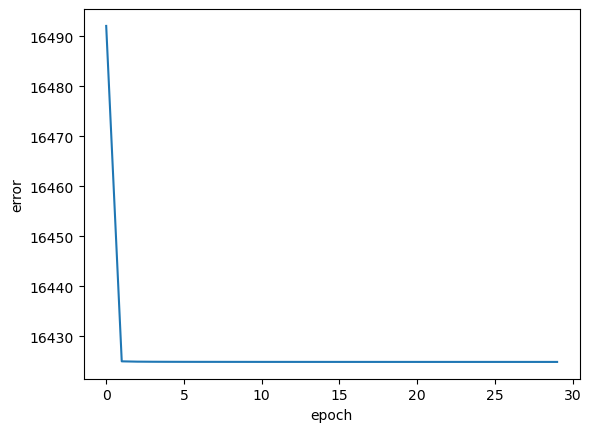

In [25]:
red.train(epochs=30, data_loader=train_loader, criterion=criterion, optimizer=optimizer, device=device, debug=True, save_dir='/kaggle/working/')

In [27]:
tp, tn, fp, fn = 0, 0, 0, 0

for input_data, label in train_loader:
    if device:
        input_data = input_data.to(device)
        label = label.to(device)
                
    output = red(input_data)
    output = torch.argmax(output, dim=1)

    if label.item() == 1:
        if output.item() == 1:
            tp += 1
        else:
            fn += 1
    else:
        if output.item() == 1:
            fp += 1
        else:
            tn += 1

print(tp, tn, fp, fn)

0 22973 0 7027
